In [1]:
import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
import arviz as az
from collections import Counter
from scipy.interpolate import griddata
import pymc3 as pm
import theano as tt

sns.set()

C:\Users\e104249\AppData\Local\Continuum\anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
# Functions
def sort_vals(vals, ascending = True):
    """sorts valus from high to low
    returns:
    idx - values in ascending or descending order
    """
    if ascending:
        idx = np.argsort(-vals)
    else:
        idx = np.argsort(vals)
    return idx


 # Chapter 5
 ### Cde 5.1

In [3]:
d = pd.read_csv('.\data\WaffleDivorce.csv', sep = ';')
d.columns = d.columns.str.lower()
d.head()

,location,loc,population,medianagemarriage,marriage,marriage se,divorce,divorce se,wafflehouses,south,slaves1860,population1860,propslaves1860
0,Alabama,AL,4.78,25.3,20.2,1.27,12.7,0.79,128,1,435080,964201,0.45
1,Alaska,AK,0.71,25.2,26.0,2.93,12.5,2.05,0,0,0,0,0.00
2,Arizona,AZ,6.33,25.8,20.3,0.98,10.8,0.74,18,0,0,0,0.00
3,Arkansas,AR,2.92,24.3,26.4,1.70,13.5,1.22,41,1,111115,435450,0.26
4,California,CA,37.25,26.8,19.1,0.39,8.0,0.24,0,0,0,379994,0.00


In [4]:
d['medianagemarriage_s'] = (d.medianagemarriage - d.medianagemarriage.mean())/ d.medianagemarriage.std()

In [5]:
shared_x = tt.shared(d.medianagemarriage_s.values)
shared_y = tt.shared(d.divorce.values)
with pm.Model() as m51:
    alpha = pm.Normal('alpha', mu = 10, sigma = 10)
    beta = pm.Normal('beta', mu = 0, sigma = 1)
    mu = pm.Deterministic('mu', alpha + beta*shared_x)
    sigma = pm.Uniform('sigma', lower = 0, upper = 10)
    divorce = pm.Normal('divorce',mu = mu, sigma = sigma, observed = shared_y)
    trace51 = pm.sample(draws = 1000,tune = 1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, beta, alpha]
Sampling 4 chains: 100%|██████████████████████████████████████████████████████| 8000/8000 [00:04<00:00, 1610.35draws/s]


In [6]:
varnames = ['alpha', 'beta','sigma']
pm.summary(trace51, varnames = varnames)

C:\Users\JOSH\Anaconda3\lib\site-packages\pymc3\stats.py:991: FutureWarning: The join_axes-keyword is deprecated. Use .reindex or .reindex_like on the result to achieve the same functionality.
  axis=1, join_axes=[dforg.index])


,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
alpha,9.691904,0.212171,0.002945,9.275962,10.104009,5062.317594,0.999828
beta,-1.035486,0.216371,0.002656,-1.445200,-0.595383,5196.923007,0.999604
sigma,1.516042,0.161880,0.002319,1.244718,1.850659,4948.113175,1.000296


 ## Code 5.2

In [7]:
new_x_values = np.linspace(-3,3.5,num = 30)
shared_x.set_value(new_x_values)
shared_y.set_value(np.repeat(0, repeats = len(new_x_values)))
with m51:
    post_pred = pm.sample_posterior_predictive(trace51,samples = 1000,model=m51)

100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:08<00:00, 112.39it/s]


In [8]:
mu_hpd = az.hpd(trace51['mu'], credible_interval=.89)
post_pred_hpd = az.hpd(post_pred['divorce'], credible_interval=.89)

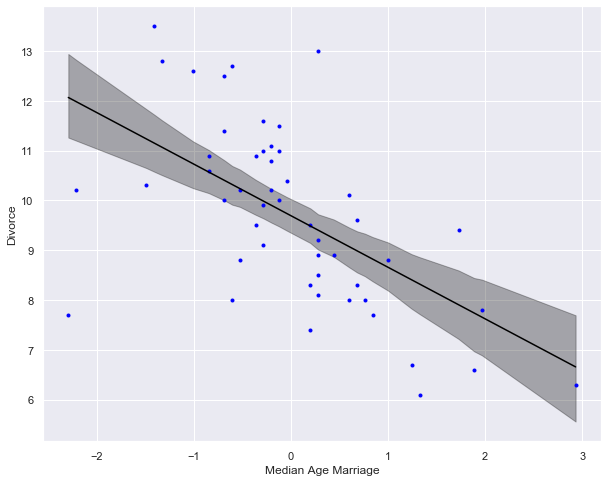

In [9]:
idx = sort_vals(d.medianagemarriage_s)
sorted_x_vals = d.medianagemarriage_s[idx]

plt.figure(figsize=(10,8))
plt.plot(d.medianagemarriage_s.values,d.divorce.values, color = 'blue', marker = '.', linestyle = '')
plt.plot(sorted_x_vals, trace51['alpha'].mean() + np.mean(trace51['beta'])*sorted_x_vals, color = 'black', alpha = 1)
plt.fill_between(sorted_x_vals, mu_hpd[idx,0], mu_hpd[idx,1], color='black', alpha=0.3)
plt.xlabel('Median Age Marriage')
plt.ylabel('Divorce')

plt.show()

 ## Code 5.3

In [10]:
d['marriage_s'] = (d.marriage - d.marriage.mean())/ d.marriage.std()

In [11]:
shared_x = tt.shared(d.marriage_s.values)
shared_y = tt.shared(d.divorce.values)
with pm.Model() as m53:
    alpha = pm.Normal('alpha', mu = 10, sigma = 10)
    beta = pm.Normal('MAM_beta', mu = 0, sigma = 1)
    mu = pm.Deterministic('mu', alpha + beta*shared_x)
    sigma = pm.Uniform('sigma', lower = 0, upper = 10)
    divorce = pm.Normal('divorce',mu = mu, sigma = sigma, observed = shared_y)
    trace53 = pm.sample(draws = 1000,tune = 1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, MAM_beta, alpha]
Sampling 4 chains: 100%|██████████████████████████████████████████████████████| 8000/8000 [00:05<00:00, 1409.06draws/s]


In [12]:
varnames_53 = ['alpha', 'MAM_beta','sigma']
pm.summary(trace53, varnames = varnames_53)

C:\Users\JOSH\Anaconda3\lib\site-packages\pymc3\stats.py:991: FutureWarning: The join_axes-keyword is deprecated. Use .reindex or .reindex_like on the result to achieve the same functionality.
  axis=1, join_axes=[dforg.index])


,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
alpha,9.690134,0.249159,0.003316,9.172913,10.153547,4961.057940,0.999687
MAM_beta,0.639008,0.239420,0.003147,0.171727,1.110376,5515.663672,0.999808
sigma,1.751520,0.189069,0.002781,1.417246,2.156498,4228.878830,0.999924


In [13]:
new_x_values = np.linspace(-3,3.5,num = 30)
shared_x.set_value(new_x_values)
shared_y.set_value(np.repeat(0, repeats = len(new_x_values)))
with m53:
    post_pred = pm.sample_posterior_predictive(trace53,samples = 1000,model=m53)

100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:09<00:00, 106.13it/s]


In [14]:
mu_hpd = az.hpd(trace53['mu'], credible_interval=.89)
post_pred_hpd = az.hpd(post_pred['divorce'], credible_interval=.89)

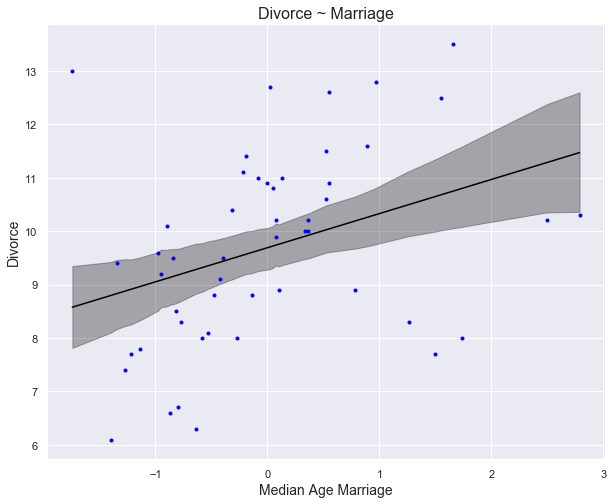

In [15]:
idx = sort_vals(d.marriage_s)
sorted_x_vals = d.marriage_s[idx]

plt.figure(figsize=(10,8))
plt.plot(d.marriage_s.values,d.divorce.values, color = 'blue', marker = '.', linestyle = '')
plt.plot(sorted_x_vals, trace53['alpha'].mean() + np.mean(trace53['MAM_beta'])*sorted_x_vals, color = 'black', alpha = 1)
plt.fill_between(sorted_x_vals, mu_hpd[idx,0], mu_hpd[idx,1], color='black', alpha=0.3)
plt.xlabel('Median Age Marriage', fontsize = 14)
plt.ylabel('Divorce', fontsize = 14)
plt.title('Divorce ~ Marriage', fontsize = 16)

plt.show()

 ## Code 5.4

In [16]:
shared_x54 = tt.shared(d[['marriage_s','medianagemarriage_s']].values)
shared_y54 = tt.shared(d.divorce.values)

with pm.Model() as m54:
    alpha = pm.Normal('alpha', mu = 10, sigma = 10)
    beta = pm.Normal('MARR_beta', mu = 0, sigma = 1)
    beta2 = pm.Normal('MAM_beta', mu = 0, sigma = 1)
    mu = pm.Deterministic('mu',alpha + beta*shared_x54.get_value()[:,0] + beta2*shared_x54.get_value()[:,1])
    sigma = pm.Uniform('sigma', lower = 0, upper = 10)
    divorce = pm.Normal('divorce',mu = mu, sigma = sigma, observed = shared_y54)
    trace54 = pm.sample(draws = 1000,tune = 1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, MAM_beta, MARR_beta, alpha]
Sampling 4 chains: 100%|███████████████████████████████████████████████████████| 8000/8000 [00:09<00:00, 802.92draws/s]


In [17]:
varnames_54 = ['alpha', 'MARR_beta','MAM_beta','sigma']
#varnames_54 = ['alpha', 'MARR_beta','sigma']
pm.summary(trace54, varnames = varnames_54, alpha = .11).round(3)

C:\Users\JOSH\Anaconda3\lib\site-packages\pymc3\stats.py:991: FutureWarning: The join_axes-keyword is deprecated. Use .reindex or .reindex_like on the result to achieve the same functionality.
  axis=1, join_axes=[dforg.index])


,mean,sd,mc_error,hpd_5.5,hpd_94.5,n_eff,Rhat
alpha,9.690,0.215,0.003,9.352,10.029,3371.023,1.000
MARR_beta,-0.113,0.287,0.006,-0.544,0.370,2911.493,1.000
MAM_beta,-1.121,0.288,0.005,-1.577,-0.667,3129.487,1.001
sigma,1.520,0.158,0.003,1.255,1.744,3344.961,1.000


In [18]:
#notice how after adding im the marriage rate of the state our signs flip from positive to negative.
# this is classic example of mulitcollinearity
pm.summary(trace53, varnames = varnames_53, alpha = .11).round(3)

C:\Users\JOSH\Anaconda3\lib\site-packages\pymc3\stats.py:991: FutureWarning: The join_axes-keyword is deprecated. Use .reindex or .reindex_like on the result to achieve the same functionality.
  axis=1, join_axes=[dforg.index])


,mean,sd,mc_error,hpd_5.5,hpd_94.5,n_eff,Rhat
alpha,9.690,0.249,0.003,9.287,10.067,4961.058,1.0
MAM_beta,0.639,0.239,0.003,0.254,1.002,5515.664,1.0
sigma,1.752,0.189,0.003,1.471,2.043,4228.879,1.0


## Code 5.5

C:\Users\JOSH\Anaconda3\lib\site-packages\arviz\plots\forestplot.py:207: MatplotlibDeprecationWarning: 
The tick1On function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use Tick.tick1line.set_visible instead.
  ticks.tick1On = False
C:\Users\JOSH\Anaconda3\lib\site-packages\arviz\plots\forestplot.py:208: MatplotlibDeprecationWarning: 
The tick2On function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use Tick.tick2line.set_visible instead.
  ticks.tick2On = False


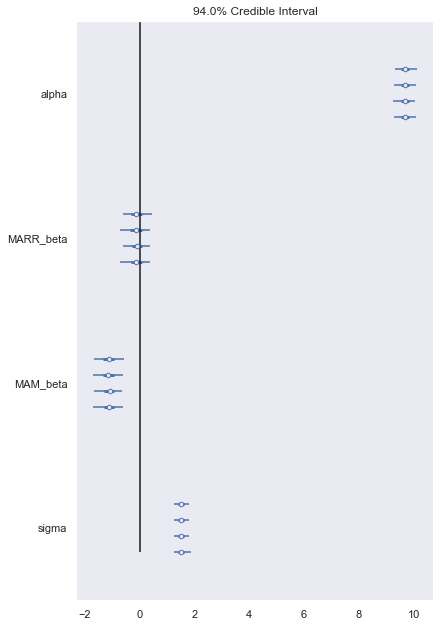

In [19]:
# interpretaion from the book, "Once we know median age of marraiage for a state there is little or no additional 
# predictive power in also knowing the rate of marriage in that state"
az.plot_forest(trace54,var_names=varnames_54)
plt.vlines(x = 0, ymin = 0, ymax = 5)

 ## Code 5.6

In [20]:
shared_x = tt.shared(d.medianagemarriage_s.values)
shared_y = tt.shared(d.marriage_s.values)
with pm.Model() as m56:
    alpha = pm.Normal('alpha', mu = 0, sigma = 10)
    beta = pm.Normal('MAM_beta', mu = 0, sigma = 1)
    mu = pm.Deterministic('mu', alpha + beta*shared_x)
    sigma = pm.Uniform('sigma', lower = 0, upper = 10)
    marriage = pm.Normal('marriage_s',mu = mu, sigma = sigma, observed = shared_y)
    trace56 = pm.sample(draws = 1000,tune = 1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, MAM_beta, alpha]
Sampling 4 chains: 100%|██████████████████████████████████████████████████████| 8000/8000 [00:07<00:00, 1039.35draws/s]


In [21]:
varnames_56 = ['alpha', 'MAM_beta','sigma']
pm.summary(trace56, varnames = varnames_56)

C:\Users\JOSH\Anaconda3\lib\site-packages\pymc3\stats.py:991: FutureWarning: The join_axes-keyword is deprecated. Use .reindex or .reindex_like on the result to achieve the same functionality.
  axis=1, join_axes=[dforg.index])


,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
alpha,0.001722,0.102383,0.001363,-0.187769,0.207494,4995.875313,0.999597
MAM_beta,-0.713676,0.102975,0.001346,-0.918317,-0.505987,5609.570806,0.999829
sigma,0.718705,0.077420,0.001057,0.577412,0.876104,5086.539832,0.999583


 ## Code 5.7

In [22]:
# computer expected value at MAP, for each State
mu = trace56['mu'].mean(0)
# compute residual for each state
resid = d.marriage_s - mu

 ## Code 5.8

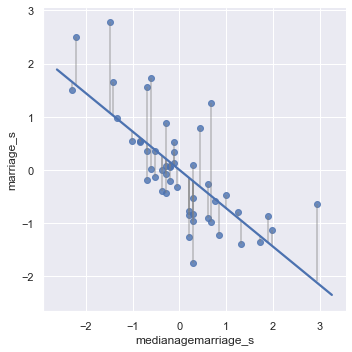

In [23]:
# These residuals from above are the variations in marriage rate which is not explained by median age of marriage.
sns.lmplot('medianagemarriage_s','marriage_s',data=d,ci = 0)
plt.vlines(d.medianagemarriage_s,mu, mu + resid, alpha = .5, color = 'grey' )

## Code 5.9 -5.10

In [24]:
# holding age constant at the mean and changing the rate what is the change in prediction. It should follow what the respecitve beta is
## shared_x54 is marriages, median_s
a_avg = d.medianagemarriage_s.mean()
r_seq = np.linspace(-3,3, num= 100)
counterfactual_data = np.array([r_seq,np.repeat(0, len(r_seq))]).T

In [25]:
mu = trace54['alpha'] + trace54['MAM_beta']*0 + trace54['MARR_beta']*r_seq[:, np.newaxis]
mu_pred = mu.mean(axis = 1)
pred = az.hpd(stats.norm.rvs(mu, trace54['sigma']).T)
mu_hpd = az.hpd(mu.T, credible_interval=.89)
pred_hpd = az.hpd(pred.T, credible_interval=.89)

(6, 14)

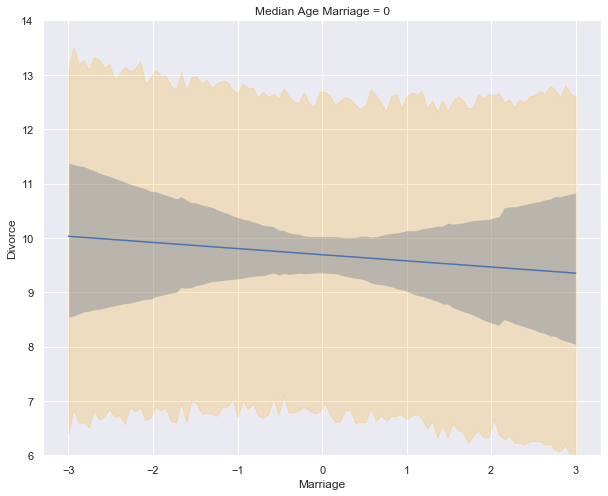

In [26]:
plt.figure(figsize = (10,8))
plt.plot(r_seq, mu_pred)
plt.fill_between(r_seq, mu_hpd[:,0], mu_hpd[:,1], alpha = .4)
plt.fill_between(r_seq, pred_hpd[:,0], pred_hpd[:,1], alpha = .2, color = 'orange')
plt.title('Median Age Marriage = 0')
plt.ylabel('Divorce')
plt.xlabel('Marriage')
plt.ylim(6,14)

In [27]:
# holding age constant at the mean and changing the rate what is the change in prediction. It should follow what the respecitve beta is
## shared_x54 is marriages, median_s
a_avg = d.marriage_s.mean()
r_seq = np.linspace(-3,3.5, num= 100)
counterfactual_data = np.array([r_seq,np.repeat(0, len(r_seq))]).T

In [28]:
mu = trace54['alpha'] + trace54['MAM_beta']*r_seq[:, np.newaxis] + trace54['MARR_beta']*0
mu_pred = mu.mean(axis = 1)
pred = az.hpd(stats.norm.rvs(mu, trace54['sigma']).T)
mu_hpd = az.hpd(mu.T, credible_interval=.89)
pred_hpd = az.hpd(pred.T, credible_interval=.89)

(6, 14)

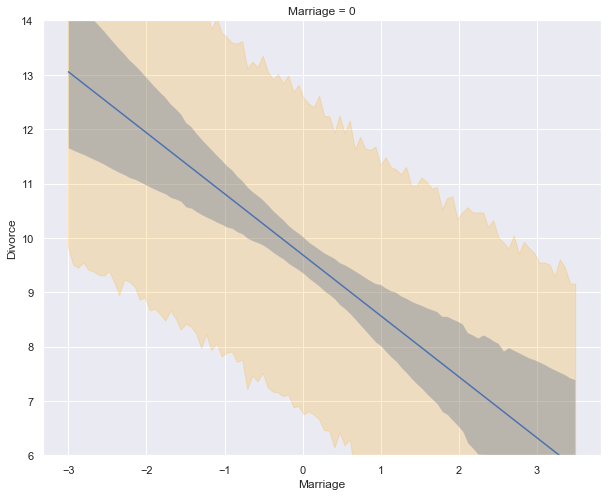

In [29]:
plt.figure(figsize = (10,8))
plt.plot(r_seq, mu_pred)
plt.fill_between(r_seq, mu_hpd[:,0], mu_hpd[:,1], alpha = .4)
plt.fill_between(r_seq, pred_hpd[:,0], pred_hpd[:,1], alpha = .2, color = 'orange')
plt.title('Marriage = 0')
plt.ylabel('Divorce')
plt.xlabel('Marriage')
plt.ylim(6,14)

## Code 5.12 - 5.13

In [51]:
# Expected value and its respective uncertainty
mu = trace54['mu']
mu_mean = mu.mean(axis = 0)
mu_hpd = az.hpd(mu, credible_interval=.89)
# Expected value with its uncertanity and the spread around mu
div_samps = pm.sample_posterior_predictive(trace54, samples = 1000, model = m54)
div_samps = div_samps['divorce']

100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:09<00:00, 107.41it/s]


In [80]:
divhpd = az.hpd(div_samps, credible_interval=.89)
divhpd[0,:].mean(0),  mu_hpd[0,:]

(10.225234659046551, array([ 9.93787284, 10.82766575]))

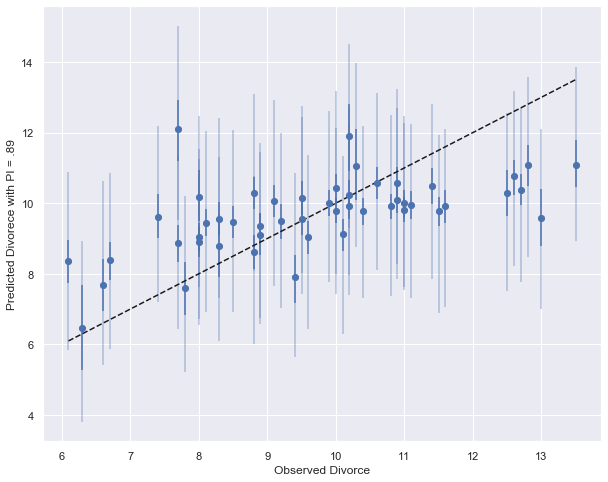

In [93]:
plt.figure(figsize = (10,8))
plt.plot(d.divorce, mu_mean, marker = '.', linestyle = '')
#plt.errorbar(d.divorce,mu_mean,mu_hpd[:,1] - mu_hpd[:,0],fmt='C0o')
plt.errorbar(d.divorce, mu_mean , yerr=np.abs(mu_mean -mu_hpd.T) , fmt='C0o', alpha = 1)
plt.errorbar(d.divorce, mu_mean , yerr=np.abs(mu_mean -divhpd.T) , fmt='C0o', alpha =.4)
plt.xlabel('Observed Divorce')
plt.ylabel('Predicted Divorece with PI = .89')
min_x, max_x = d.divorce.min(), d.divorce.max()
plt.plot([min_x, max_x], [min_x, max_x], 'k--');

## Code 5.14

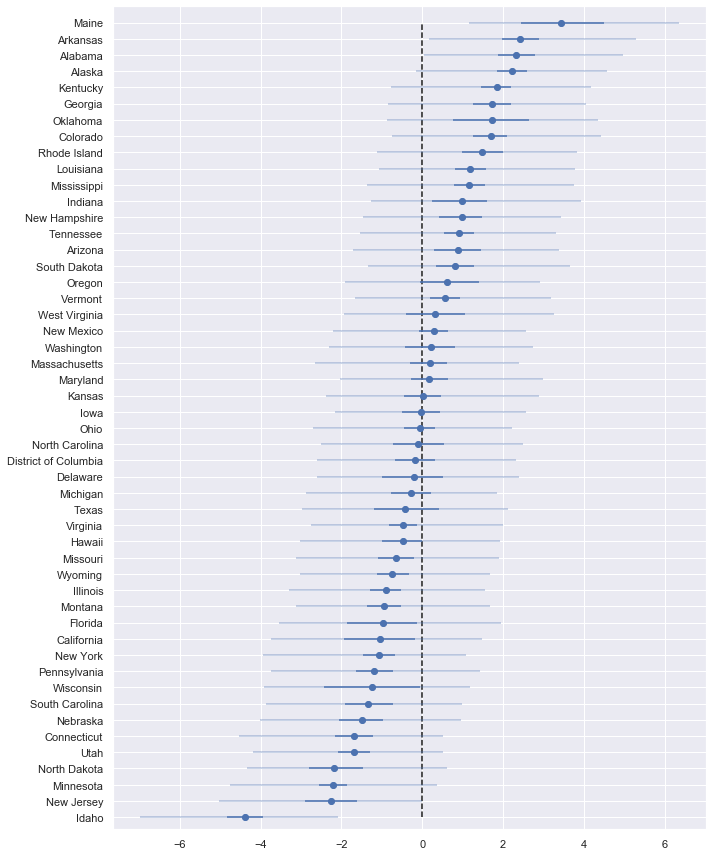

In [127]:

divorce_resid = d.divorce - mu_mean
o = np.argsort(divorce_resid)
y_ax = np.arange(0, len(d.divorce))
y_text = d.location	[o]
plt.figure(figsize = (10,12))
plt.vlines(0, ymin = np.min(y_ax), ymax = np.max(y_ax), linestyle = '--')
plt.plot(divorce_resid[o], y_ax, marker = '.', linestyle = '')
plt.errorbar(divorce_resid[o], y_ax, xerr= np.abs(mu_mean -mu_hpd.T) , fmt='C0o', alpha = 1)
plt.errorbar(divorce_resid[o], y_ax , xerr=np.abs(mu_mean -divhpd.T) , fmt='C0o', alpha =.4)
plt.yticks(y_ax, y_text)
plt.ylim(-.75,50)
plt.tight_layout()
plt.show()

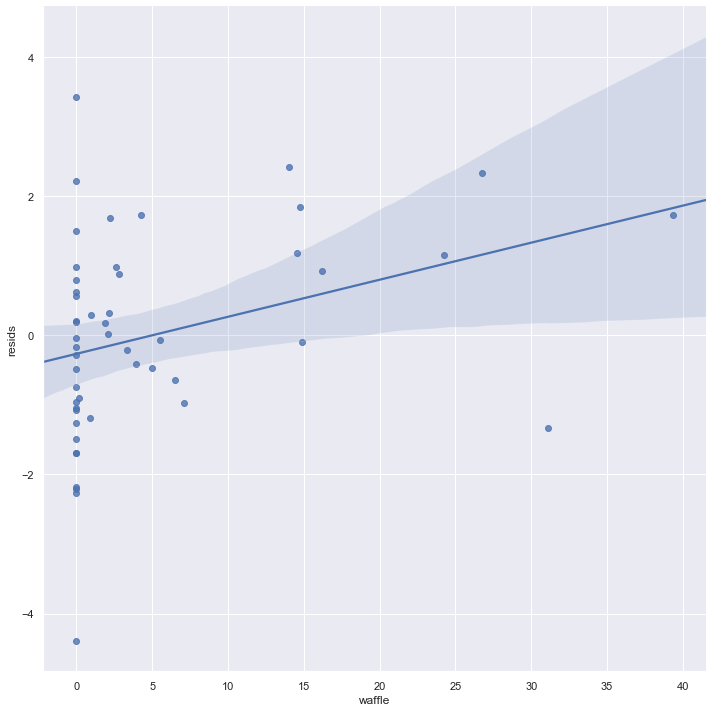

In [151]:
# After Controlling for everything there is a correlation with waffle houses
data = pd.DataFrame(np.array([d.wafflehouses.values/d.population.values, divorce_resid]).T, columns = ['waffle','resids'])
sns.lmplot('waffle','resids', data = data,height = 10)

## Code 5.15

In [158]:
n = 100
x_real = np.random.normal(size = n)
x_spur = np.random.normal(loc = x_real, size = n)
y = np.random.normal(loc = x_real, size = n)
d = pd.DataFrame(np.array([y, x_real, x_spur]).T, columns=['y','xreal','xspur'])

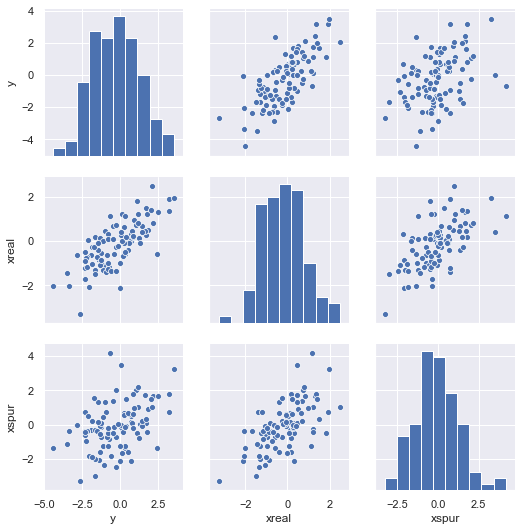

In [160]:
sns.pairplot(d)
plt.show()

## Code 5.16-17

In [3]:
d = pd.read_csv('.\\data\\milk.csv', sep = ';')
d.columns = d.columns.str.replace('.','_') 

In [4]:
shared_x55 = tt.shared(d.neocortex_perc.values)
shared_y55 = tt.shared(d.kcal_per_g.values)

In [ ]:
with pm.Model() as m55:
    alpha = pm.Normal('alpha',mu = 0, sigma = 100)
    beta = pm.Normal('beta',mu = 0, sigma = 1)
    sigma = pm.Uniform('sigma', lower = 0, upper = 1)
    mu = pm.Deterministic('mu', alpha + beta*shared_x55.get_value())
    kcal_per_g = pm.Normal('kcal', mu = mu, sigma = sigma, observed = shared_y55.get_value())
    trace55 = pm.sample(draws = 1000, tune = 1000,cores = 3)

WARNING (theano.gof.compilelock): Overriding existing lock by dead process '31216' (I am process '29464')
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, beta, alpha]
Sampling 4 chains:   0%|                                                                   | 0/8000 [00:00<?, ?draws/s]

## Code 5.18

In [7]:
d.neocortex_perc

0     55.16
1       NaN
2       NaN
3       NaN
4       NaN
5     64.54
6     64.54
7     67.64
8       NaN
9     68.85
10    58.85
11    61.69
12    60.32
13      NaN
14      NaN
15    69.97
16      NaN
17    70.41
18      NaN
19    73.40
20      NaN
21    67.53
22      NaN
23    71.26
24    72.60
25      NaN
26    70.24
27    76.30
28    75.49
Name: neocortex_perc, dtype: float64

## Code 5.19

In [6]:
dcc = d[~d.neocortex_perc.isna()].copy()

## Code 5.20 - 22

In [10]:
shared_x55 = tt.shared(dcc.neocortex_perc.values)
shared_y55 = tt.shared(dcc.kcal_per_g.values)

In [12]:
with pm.Model() as m55:
    alpha = pm.Normal('alpha',mu = 0, sigma = 100)
    beta = pm.Normal('beta',mu = 0, sigma = 1)
    sigma = pm.Uniform('sigma', lower = 0, upper = 1)
    mu = pm.Deterministic('mu', alpha + beta*shared_x55.get_value())
    kcal_per_g = pm.Normal('kcal', mu = mu, sigma = sigma, observed = shared_y55.get_value())
    trace55 = pm.sample(draws = 1000, tune = 2000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, beta, alpha]
Sampling 4 chains: 100%|█████████████████████████████████████████████████████| 12000/12000 [00:22<00:00, 539.25draws/s]
There were 34 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.5643519739818865, but should be close to 0.8. Try to increase the number of tuning steps.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
There were 5 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.


In [14]:
varnames_55 = ['alpha','beta','sigma']
pm.summary(trace55, var_names=varnames_55,alpha = .11).round(3)

C:\Users\JOSH\Anaconda3\lib\site-packages\pymc3\stats.py:991: FutureWarning: The join_axes-keyword is deprecated. Use .reindex or .reindex_like on the result to achieve the same functionality.
  axis=1, join_axes=[dforg.index])


,mean,sd,mc_error,hpd_5.5,hpd_94.5,n_eff,Rhat
alpha,0.334,0.564,0.020,-0.549,1.207,683.338,1.000
beta,0.005,0.008,0.000,-0.008,0.018,683.105,1.000
sigma,0.193,0.041,0.002,0.132,0.254,424.816,1.004


In [18]:
trace55['beta'].mean()*(76-55)

0.10050771794996866

## Code 5.23

In [58]:
np_seq = np.linspace(55,80)
mu = trace55['alpha'] + trace55['beta']*np_seq[:, None]
mu_hpd = az.hpd(mu.T, credible_interval=.89)

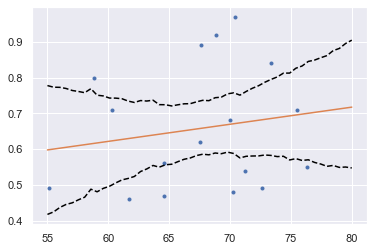

In [55]:
plt.plot(d.neocortex_perc, d.kcal_per_g, marker = '.', linestyle = '')
plt.plot(np_seq, mu.mean(axis = 1))
plt.plot(np_seq, mu_hpd[:,1], linestyle = '--', color ='black')
plt.plot(np_seq, mu_hpd[:,0], linestyle = '--', color = 'black')
plt.show()

## Code 5.24-25

In [7]:
dcc['log_mass'] = np.log(dcc.mass)
shared_x56 = tt.shared(dcc.log_mass.values)
shared_y56 = tt.shared(dcc.kcal_per_g.values)

In [61]:
with pm.Model() as m56:
    alpha = pm.Normal('alpha', mu =0, sigma = 100)
    beta =  pm.Normal('beta', mu = 0, sigma = 1)
    sigma = pm.Uniform('sigma', lower = 0, upper =10)
    mu = pm.Deterministic('mu', alpha + beta*shared_x56)
    kcal = pm.Normal('kcal', mu = mu, sigma = sigma, observed = shared_y56)
    trace56 = pm.sample(draws=1000, tune = 1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, beta, alpha]
Sampling 4 chains: 100%|██████████████████████████████████████████████████████| 8000/8000 [00:05<00:00, 1364.66draws/s]


In [64]:
varnames_56 = ['alpha','beta','sigma']
pm.summary(trace56, var_names=varnames_56,alpha = .11).round(3)

C:\Users\JOSH\Anaconda3\lib\site-packages\pymc3\stats.py:991: FutureWarning: The join_axes-keyword is deprecated. Use .reindex or .reindex_like on the result to achieve the same functionality.
  axis=1, join_axes=[dforg.index])


,mean,sd,mc_error,hpd_5.5,hpd_94.5,n_eff,Rhat
alpha,0.706,0.058,0.001,0.611,0.793,2037.424,1.001
beta,-0.032,0.024,0.000,-0.072,0.004,2288.955,1.001
sigma,0.183,0.038,0.001,0.125,0.232,1694.997,1.000


In [71]:
lm_seq = np.linspace(dcc.log_mass.min(), dcc.log_mass.max())
mu = trace56['alpha'] + trace56['beta']*lm_seq[:,None]
mu_hpd = az.hpd(mu.T,credible_interval=.89)

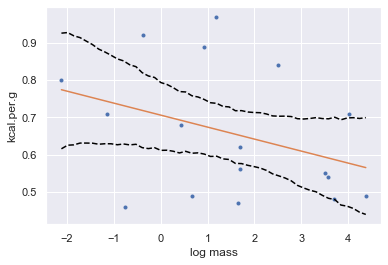

In [78]:
plt.plot(dcc.log_mass, dcc.kcal_per_g, marker = '.', linestyle = '')
plt.plot(lm_seq, mu.mean(1))
plt.plot(lm_seq, mu_hpd[:,0], linestyle = '--', color = 'black')
plt.plot(lm_seq, mu_hpd[:,1], linestyle = '--', color = 'black')
plt.xlabel('log mass')
plt.ylabel('kcal.per.g')
plt.show()

## Code 5.26-27


In [8]:
shared_x57 = tt.shared(dcc[['neocortex_perc','log_mass']].values)
shared_y57 = tt.shared(dcc.kcal_per_g.values)

In [10]:
with pm.Model() as m57:
    alpha = pm.Normal('alpha', mu =0, sigma = 100)
    beta1 =  pm.Normal('beta_bn', mu = 0, sigma = 1)
    beta2 =  pm.Normal('beta_blm', mu = 0, sigma = 1)
    sigma = pm.Uniform('sigma', lower = 0, upper =10)
    mu = pm.Deterministic('mu', alpha + beta1*shared_x57.get_value()[:,0] + beta2*shared_x57.get_value()[:,1])
    kcal = pm.Normal('kcal', mu = mu, sigma = sigma, observed = shared_y57)
    trace57 = pm.sample(draws=1000, tune = 1000)
    

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, beta_blm, beta_bn, alpha]
Sampling 4 chains: 100%|███████████████████████████████████████████████████████| 8000/8000 [00:20<00:00, 389.66draws/s]
There were 43 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6323981525242293, but should be close to 0.8. Try to increase the number of tuning steps.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
There were 14 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6806613996000547, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.


In [12]:
varnames_57 = ['alpha','beta_bn','beta_blm','sigma']
pm.summary(trace57, var_names=varnames_57,alpha = .11).round(3)

C:\Users\e104249\AppData\Local\Continuum\anaconda3\lib\site-packages\pymc3\stats.py:991: FutureWarning: The join_axes-keyword is deprecated. Use .reindex or .reindex_like on the result to achieve the same functionality.
  axis=1, join_axes=[dforg.index])


,mean,sd,mc_error,hpd_5.5,hpd_94.5,n_eff,Rhat
alpha,-1.102,0.623,0.023,-2.125,-0.174,635.695,1.003
beta_bn,0.028,0.010,0.000,0.014,0.045,620.853,1.003
beta_blm,-0.097,0.030,0.001,-0.146,-0.053,587.883,1.004
sigma,0.140,0.030,0.001,0.097,0.183,532.213,1.000


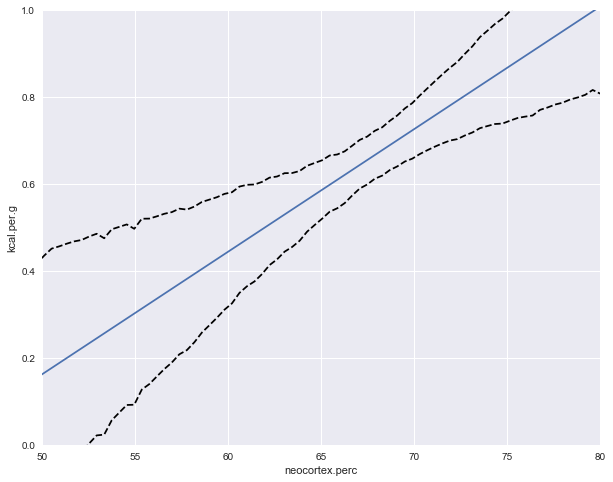

In [38]:
mean_log_mass = np.mean(dcc.log_mass)
np_seq = np.linspace(40,80,100)
mu = trace57['alpha'] + trace57['beta_bn']*np_seq[:, None] + trace57['beta_blm']*mean_log_mass
mu_hpd = az.hpd(mu.T, credible_interval=.89)
plt.figure(figsize = (10,8))
plt.plot(np_seq, mu.mean(axis = 1))
plt.plot(np_seq, mu_hpd[:,1], linestyle = '--', color ='black')
plt.plot(np_seq, mu_hpd[:,0], linestyle = '--', color = 'black')
plt.ylim(0,1)
plt.xlim(50,80)
plt.xlabel('neocortex.perc')
plt.ylabel('kcal.per.g')
plt.show()

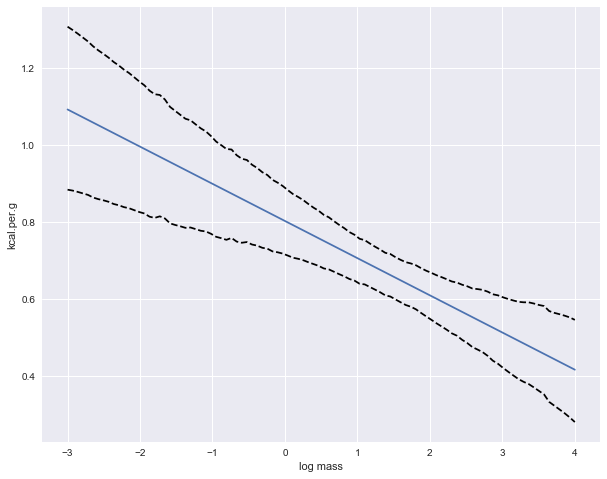

In [39]:
mean_neo = np.mean(dcc.neocortex_perc)
np_seq = np.linspace(-3,4,100)
mu = trace57['alpha'] + trace57['beta_bn']*mean_neo + trace57['beta_blm']*np_seq[:, None]
mu_hpd = az.hpd(mu.T, credible_interval=.89)
plt.figure(figsize = (10,8))
plt.plot(np_seq, mu.mean(axis = 1))
plt.plot(np_seq, mu_hpd[:,1], linestyle = '--', color ='black')
plt.plot(np_seq, mu_hpd[:,0], linestyle = '--', color = 'black')
plt.xlabel('log mass')
plt.ylabel('kcal.per.g')
plt.show()

## Code 5.28


In [62]:
n = 100
rho = .7
x_pos = np.random.normal(size = n)
x_neg = np.random.normal(loc = rho*x_pos,scale = np.sqrt(1-rho**2),size = n)
y = np.random.normal(x_pos - x_neg, size = n)
d = pd.DataFrame(np.array([x_pos, x_neg, y]).T, columns = ['x_pos','x_neg','y'])


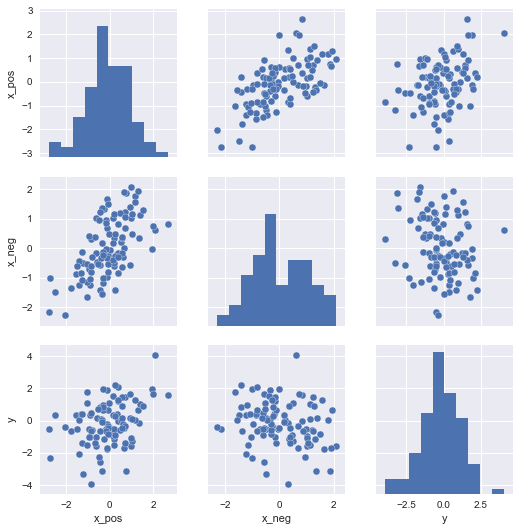

In [65]:
sns.pairplot(d)
plt.show()